## Feature Compression
iDCT, PCAs, Mean Pooling, Max Pooling, 

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from sklearn.decomposition import PCA, KernelPCA
from scipy.fftpack import dct, idct
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning

In [2]:
from scipy.fftpack import dct, idct
import numpy as np

def iDCTquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    for i in range(len(trans)):
        trans[i] = scale(trans[i])
    return trans.T

def scale(v):
    M = np.max(v)
    m = np.min(v)
    return (v - m) / float(M - m)

def quant2D(emb,n=5,m=44):
    dct = iDCTquant(emb[1:len(emb)-1],n)
    ddct = iDCTquant(dct.T,m).T
    ddct = ddct.reshape(n*m)
    return (ddct*127).astype('int8')

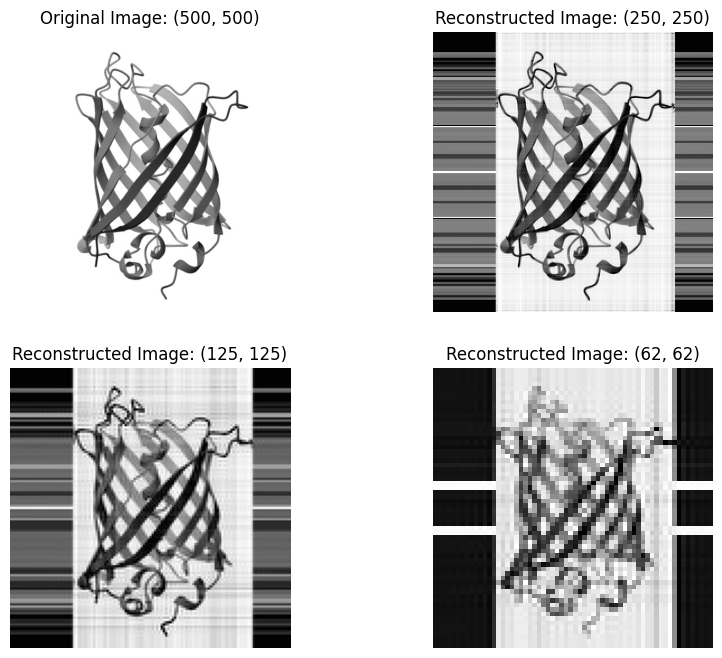

In [4]:
#################################### iDCT Adapted version #########################################
def iDCTquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    for i in range(len(trans)):
        trans[i] = scale(trans[i])
    return trans.T

def scale(v):
    M = np.max(v)
    m = np.min(v)
    return (v - m) / float(M - m)

def quant2D(emb,n=5,m=44):
    dct = iDCTquant(emb[1:len(emb)-1],n)
    ddct = iDCTquant(dct.T,m).T
    #ddct = ddct.reshape(n*m)
    return (ddct*127).astype('int8')



# Load an image (you can replace this with your own image file)
image = plt.imread('GFP_1GFL.jpeg')

# Convert the image to grayscale
image = np.mean(image, axis=2)

n=125
m=125

recon1 = quant2D(image,250,250)
recon2 = quant2D(image,n,m)
recon3 = quant2D(image,62,62)

# Plot the original image and the reconstructed image
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0,0].imshow(image, cmap='gray')
axs[0,0].set_title(f'Original Image: {image.shape}')
axs[0,0].axis('off')

axs[0,1].imshow(recon1, cmap='gray')
axs[0,1].set_title(f'Reconstructed Image: {recon1.shape}')
axs[0,1].axis('off')


axs[1,0].imshow(recon2, cmap='gray')
axs[1,0].set_title(f'Reconstructed Image: {recon2.shape}')
axs[1,0].axis('off')

axs[1,1].imshow(recon3, cmap='gray')
axs[1,1].set_title(f'Reconstructed Image: {recon3.shape}')
axs[1,1].axis('off')

#plt.savefig('banner.png', dpi=300)
plt.show()

In [2]:
def features_scaler(features):
    '''Scale the features by min-max scaler, to ensure that the features selected by Lasso are not biased by the scale of the features.
    Also, the features are scaled across the rows, i.e., the features are scaled across the sequence length.'''
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    scaled_features = scaler.fit_transform(features)
    return pd.DataFrame(scaled_features)

def pca_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using PCA.
    First I transposed the embeddings, because PCA works on the features, not on the samples.
    So my features will be the sequence length and the samples will be the model dimensions.
    After PCA, I transposed the embeddings back to obtain a single vector of the transformed embeddings,
    each row will represented by a pca of model dimentsions'''
    features = features_scaler(embeddings).T
    pca = PCA(num_pca_components)
    embed_trans = pca.fit_transform(features)
    return embed_trans.T

def kernel_pca_rbf_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using kernel PCA'''
    features = features_scaler(embeddings).T
    kpca_rbf = KernelPCA(kernel="rbf", gamma=None, n_components=num_pca_components, n_jobs=16)
    kpca_rbf_features = kpca_rbf.fit_transform(features)
    return kpca_rbf_features.T

def kernel_pca_sigmoid_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using kernel PCA'''
    features = features_scaler(embeddings).T
    kpca_sigmoid = KernelPCA(kernel="sigmoid", gamma=None, n_components=num_pca_components, n_jobs=16)
    kpca_sigmoid_features = kpca_sigmoid.fit_transform(features)
    return kpca_sigmoid_features.T

def tSNE_transformation(embeddings, num_pca_components=2):
    '''Transform the embeddings using tSNE'''
    features = features_scaler(embeddings).T
    tSNE_model = TSNE(n_components=num_pca_components, n_jobs=16, metric='cosine')
    tSNE_features = tSNE_model.fit_transform(features)
    return tSNE_features.T



def iDCTquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    return trans.T

def quant2D(emb, n=64, m=80): # final vector length 5120
    dct = iDCTquant(emb,n)
    ddct = iDCTquant(dct.T,m).T
    ddct = ddct.reshape(n*m) # turn a 2D array into a 1D vector
    return ddct
    

## Figure 2 - features not scaled

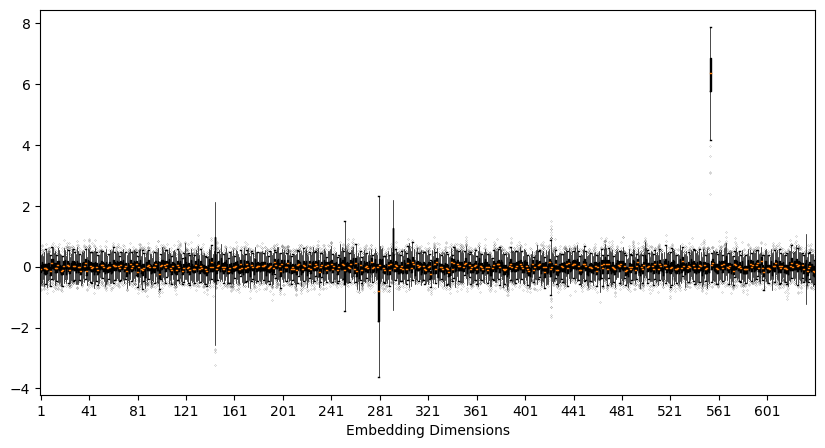

In [24]:
# features not scaled
plt.figure(figsize=(10, 5))
mtx = torch.load('embeddings/DMS/AMIE_PSEAE_Whitehead_esm2_150M/AMIE_PSEAE_A16A.pt')['representations'][30].numpy()

# Define properties for various parts of the boxplot
flierprops = {'marker': 'o', 'markersize': 0.1}
whiskerprops = {'linewidth': 0.5}
capprops = {'color': 'green', 'linewidth': 1}
medianprops = {'color': 'red', 'linewidth': 2}

# Create the boxplot
plt.boxplot(mtx, 
            flierprops=flierprops, 
            whiskerprops=whiskerprops, 
            #capprops=capprops, 
            #medianprops=medianprops
)
 
#plt.boxplot(mtx, flierprops={'marker': 'o', 'markersize': 0.1})
plt.xlabel('Embedding Dimensions')
plt.xticks(range(1, mtx.shape[1]+1, 40), labels=range(1, mtx.shape[1]+1, 40))
plt.show()

## Figure 3 - features not scaled

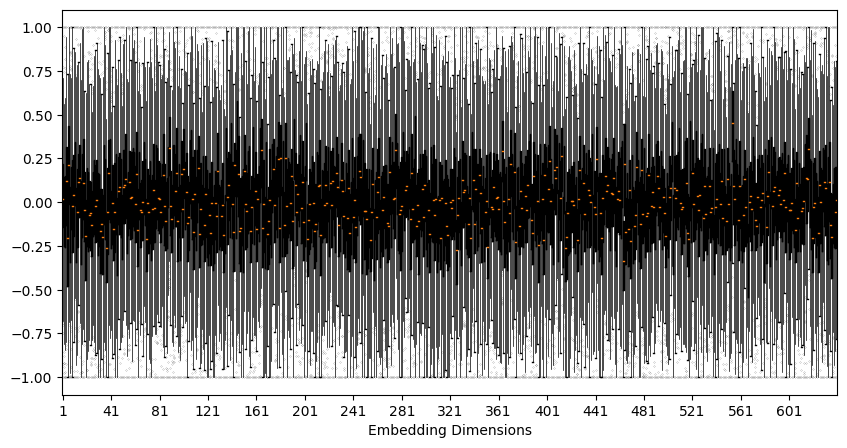

In [26]:
plt.figure(figsize=(10, 5))
mtx = torch.load('embeddings/DMS/AMIE_PSEAE_Whitehead_esm2_150M/AMIE_PSEAE_A16A.pt')['representations'][30].numpy()

# Define properties for various parts of the boxplot
flierprops = {'marker': 'o', 'markersize': 0.1}
whiskerprops = {'linewidth': 0.5}
capprops = {'color': 'green', 'linewidth': 1}
medianprops = {'color': 'red', 'linewidth': 2}

# Create the boxplot
plt.boxplot(features_scaler(mtx), 
            flierprops=flierprops, 
            whiskerprops=whiskerprops, 
            #capprops=capprops, 
            #medianprops=medianprops
)

plt.xlabel('Embedding Dimensions')
plt.xticks(range(1, mtx.shape[1]+1, 40), labels=range(1, mtx.shape[1]+1, 40))
plt.show()

## Load embeddings and applying compressing method

In [4]:
def load_per_tok_embeds(dir_path, compression_method, rep_layer=30):
    embeddings = {}
    count=0
    for file in os.listdir(dir_path):
        if file.endswith('.pt'):
            file_path = os.path.join(dir_path, file)
            label = file.split('.pt')[0]

            if compression_method == 'mean':
                embed = np.array(torch.load(file_path)['mean_representations'][rep_layer])
                embeddings[label] = embed
                
            elif compression_method == 'bos':
                embed = np.array(torch.load(file_path)['bos_representations'][rep_layer])
                embeddings[label] = embed
                
            elif compression_method == 'maxPool':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = embed.max(axis=0)
                embeddings[label] = embed_trans
                
            elif compression_method == 'pca1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans[0]
                
            elif compression_method == 'pca2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans[1]
                
            elif compression_method == 'pca1-2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = pca_transformation(embed)
                embeddings[label] = embed_trans.reshape(-1)
                
            elif compression_method == 'rbf1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_rbf_transformation(embed)
                embeddings[label] = embed_trans[0]
                
            elif compression_method == 'rbf2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_rbf_transformation(embed)
                embeddings[label] = embed_trans[1]
                
            elif compression_method == 'sigmoid1':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_sigmoid_transformation(embed)
                embeddings[label] = embed_trans[0]
                
            elif compression_method == 'sigmoid2':
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embed_trans = kernel_pca_sigmoid_transformation(embed)
                embeddings[label] = embed_trans[1]
                
            elif compression_method == 'iDCT1': #v01 original implementation
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embeddings[label] = quant2D(embed, n=5, m=44)
                
            elif compression_method == 'iDCT2': #v02 (n=10, m=64), final dimention 640 same as esm2_150M
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embeddings[label] = quant2D(embed, n=10, m=64) 
                
            elif compression_method == 'iDCT3': #v03 (n=10, m=128), final dimention 1280 same as esm2_650M 
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embeddings[label] = quant2D(embed, n=10, m=128) 
                
            elif compression_method == 'iDCT4': #v04 (n=10, m=512), final dimention 5120 same as esm2_15B
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embeddings[label] = quant2D(embed, n=10, m=512)
                
            elif compression_method == 'iDCT5': #v05 (n=10, m=640), final dimention 6400
                embed = np.array(torch.load(file_path)['representations'][rep_layer])
                embeddings[label] = quant2D(embed, n=10, m=640)
                
        
            else:
                raise ValueError('Invalid compression method')
                print('Valid compression methods are: mean, bos, max_pool, pca1, pca2, pca1-2, rbf1, rbf2, sigmoid1, sigmoid2')
          

        count+=1
        if count % 900 == 0:
            print(f'{count} files compressed')

    return embeddings

In [ ]:
dir_path = 'embeddings/DMS_all/esm2_150M/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
for i in ['mean', 'bos', 'maxPool', 'pca1', 'pca2', 'iDCT1', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    #with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
        #pickle.dump(embed, f)

## Regressin Model - LassoCV

In [4]:
def features_scaler(features):
    '''Scale the features by min-max scaler, to ensure that the features selected by Lasso are not biased by the scale of the features.
    Also, the features are scaled across the rows, i.e., the features are scaled across the sequence length.'''
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_features = scaler.fit_transform(features)
    return pd.DataFrame(scaled_features)


def run_regression(features, target):
    '''this version computes y_pred for train and test sets'''
    # Initialize lists for storing results
    folds, num_nonzero_coefs = [], []
    r2s_train, maes_train, rmses_train = [], [], []
    r2s_test, maes_test, rmses_test = [], [], []
    rhos_train, rhos_test = [], []

    # Define the KFold cross-validator
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Loop over the KFold splits
    for kfold, (train_index, test_index) in enumerate(kf.split(features)):
        # Split the data into training and testing sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Define and train the regression model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            model = LassoCV(cv=None, random_state=42, max_iter=1000, tol=1e-2, n_jobs=-1)
            #model = LassoCV(max_iter=1000, tol=1e-2, n_jobs=-1)
            model.fit(X_train, y_train)

            # get the number of non-zero coefficients
            coeficients = model.coef_
            num_nonzero_coef = np.sum(coeficients != 0)

            # Make predictions
            y_pred_train = pd.DataFrame(model.predict(X_train))
            y_pred_test = pd.DataFrame(model.predict(X_test))

            # Evaluate the model
            r2_train = metrics.r2_score(y_train, y_pred_train)
            mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
            mse_train = metrics.mean_squared_error(y_train, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            rho_train, p_value_train = spearmanr(y_train, y_pred_train)

            r2_test = metrics.r2_score(y_test, y_pred_test)
            mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
            mse_test = metrics.mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)
            rho_test, p_value_test = spearmanr(y_test, y_pred_test)

            # Append results
            r2s_train.append(r2_train)
            maes_train.append(mae_train)
            rmses_train.append(rmse_train)

            r2s_test.append(r2_test)
            maes_test.append(mae_test)
            rmses_test.append(rmse_test)

            rhos_train.append(rho_train)
            rhos_test.append(rho_test)

            folds.append(kfold + 1)
            num_nonzero_coefs.append(num_nonzero_coef)

        # Return the collected results
        print(f"Results:  fold {kfold}, r2_train: {r2_train:.3f}, r2_test: {r2_test:.3f}, Num coefs: {num_nonzero_coef}")
    print(f"Results:  r2_train: {np.mean(r2s_train):.2f}, r2_test: {np.mean(r2s_test):.2f}, Num coefs: {np.mean(num_nonzero_coefs):.2f}")
    return r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs


def save_results(r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs):
    # Create dictionary for results
    res_dict = {
        "Model": ['Lasso'] * 5,
        "Fold": folds,
        "R2_score_train": r2s_train,
        "MAE_score_train": maes_train,
        "RMSE_score_train": rmses_train,
        "R2_score_test": r2s_test,
        "MAE_score_test": maes_test,
        "RMSE_score_test": rmses_test,
        "rho_score_train": rhos_train,
        "rho_score_test": rhos_test,
        "nun_zero_coefs": num_nonzero_coefs
    }

    # Convert results to DataFrame
    results = pd.DataFrame(res_dict).reset_index(drop=True)
    return results



def run_regression_on_compressed_files(embeddings, path_meta_data):
    '''Run regression on compressed embeddings'''
    
    results = pd.DataFrame()
    meta_data = pd.read_csv(path_meta_data)
    embed = embeddings

    embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
    embed_df.rename(columns={'index': 'ID'}, inplace=True)
    data = meta_data.merge(embed_df, how='inner', left_on='ID', right_on='ID')
    target = data['target']
    features = data.iloc[:, meta_data.shape[1]:]
    features = features_scaler(features)
    
    # run regression
    r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs = run_regression(features, target)
    res = save_results(r2s_train, maes_train, rmses_train, r2s_test, maes_test, rmses_test, rhos_train, rhos_test, folds, num_nonzero_coefs)
    results = pd.concat([results, res], axis=0)

    return results


## Testing Feature compression on DMS datasets
### BLAT_ECOLX_Tenaillon2013

In [17]:
results = pd.DataFrame()
dir_path = 'embeddings/DMS/esm2_150M/BLAT_ECOLX_Tenaillon2013/'
#for m in ['mean', 'bos', 'maxPool', 'pca1', 'iDCT1', 'rbf1', 'sigmoid1']:
for m in ['mean']:
    print(f'Compressing embeddings using {m}')
    embed = load_per_tok_embeds(dir_path, m)
    path_meta_data = 'data/DMS_metadata/BLAT_ECOLX_Tenaillon2013_metadata.csv'
    res = run_regression_on_compressed_files(embed, path_meta_data)
    res['compression_method'] = m
    results = pd.concat([results, res], axis=0)

results

Compressing embeddings using mean
900 files compressed
Results:  fold 0, r2_train: 0.612, r2_test: 0.438, Num coefs: 96
Results:  fold 1, r2_train: 0.603, r2_test: 0.524, Num coefs: 99
Results:  fold 2, r2_train: 0.680, r2_test: 0.534, Num coefs: 144
Results:  fold 3, r2_train: 0.577, r2_test: 0.389, Num coefs: 80
Results:  fold 4, r2_train: 0.639, r2_test: 0.457, Num coefs: 108
Results:  r2_train: 0.62, r2_test: 0.47, Num coefs: 105.40


,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,compression_method
0,Lasso,1,0.612167,0.935516,1.219407,0.437582,1.127804,1.443866,0.723516,0.606994,96,mean
1,Lasso,2,0.603409,0.961057,1.238314,0.523577,1.028163,1.301170,0.723630,0.643378,99,mean
2,Lasso,3,0.679980,0.854142,1.098259,0.533802,1.061489,1.359431,0.750210,0.700918,144,mean
3,Lasso,4,0.577332,0.977159,1.239202,0.388859,1.191859,1.651845,0.695479,0.659803,80,mean
4,Lasso,5,0.639039,0.925911,1.191993,0.456980,1.049106,1.336168,0.735997,0.571734,108,mean


In [44]:
results = pd.DataFrame()
dir_path = 'embeddings/DMS/BLAT_ECOLX_Tenaillon2013_esm2_150M/'
for m in ['mean', 'bos', 'maxPool', 'pca1', 'iDCT1', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {m}')
    embed = load_per_tok_embeds(dir_path, m)
    path_meta_data = 'data/metadata_DMS/BLAT_ECOLX_Tenaillon2013_metadata.csv'
    res = run_regression_on_compressed_files(embed, path_meta_data)
    res['compression_method'] = m
    results = pd.concat([results, res], axis=0)

results

Compressing embeddings using mean
900 files compressed
Results:  fold 0, r2_train: 0.607, r2_test: 0.438, Num coefs: 98
Results:  fold 1, r2_train: 0.603, r2_test: 0.516, Num coefs: 99
Results:  fold 2, r2_train: 0.687, r2_test: 0.528, Num coefs: 149
Results:  fold 3, r2_train: 0.566, r2_test: 0.360, Num coefs: 76
Results:  fold 4, r2_train: 0.655, r2_test: 0.456, Num coefs: 113
Results:  r2_train: 0.62, r2_test: 0.46, Num coefs: 107.00
Compressing embeddings using bos
900 files compressed
Results:  fold 0, r2_train: 0.306, r2_test: 0.164, Num coefs: 31
Results:  fold 1, r2_train: 0.296, r2_test: 0.322, Num coefs: 47
Results:  fold 2, r2_train: 0.304, r2_test: 0.255, Num coefs: 49
Results:  fold 3, r2_train: 0.344, r2_test: 0.211, Num coefs: 46
Results:  fold 4, r2_train: 0.356, r2_test: 0.237, Num coefs: 55
Results:  r2_train: 0.32, r2_test: 0.24, Num coefs: 45.60
Compressing embeddings using maxPool
900 files compressed
Results:  fold 0, r2_train: 0.497, r2_test: 0.379, Num coefs: 58

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,compression_method
0,Lasso,1,0.607232,0.946760,1.227140,0.437610,1.126067,1.443830,0.713187,0.608608,98,mean
1,Lasso,2,0.602598,0.965573,1.239578,0.515739,1.041426,1.311830,0.719748,0.625447,99,mean
2,Lasso,3,0.687240,0.845397,1.085730,0.528325,1.069311,1.367395,0.749553,0.700285,149,mean
3,Lasso,4,0.566035,0.992938,1.255653,0.360491,1.226081,1.689748,0.684094,0.636270,76,mean
4,Lasso,5,0.654563,0.906750,1.166079,0.456110,1.041701,1.337238,0.734272,0.572207,113,mean
0,Lasso,1,0.306293,1.342237,1.630851,0.164460,1.462002,1.759871,0.547138,0.335631,31,bos
1,Lasso,2,0.296367,1.358220,1.649424,0.322235,1.308347,1.551949,0.534637,0.539694,47,bos
2,Lasso,3,0.303933,1.326739,1.619726,0.254706,1.448827,1.718843,0.539518,0.513944,49,bos
3,Lasso,4,0.344360,1.272370,1.543387,0.211125,1.460221,1.876734,0.550488,0.513459,46,bos
4,Lasso,5,0.356060,1.301920,1.592086,0.237401,1.323037,1.583439,0.569945,0.441340,55,bos


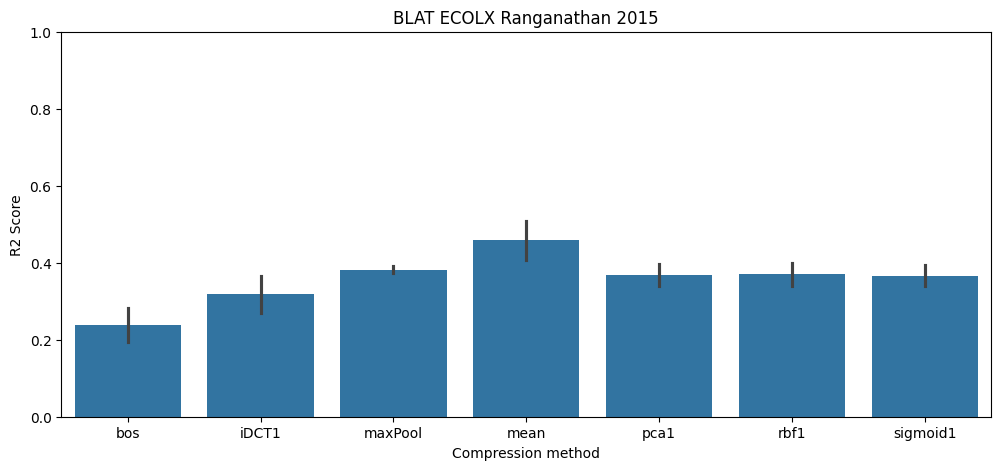

In [ ]:
results.sort_values('compression_method', inplace=True)

plt.figure(figsize=(12, 5))
sns.barplot(data=results, x='compression_method', y='R2_score_test')
plt.title('BLAT ECOLX Tenaillon 2013')
plt.ylim(0, 1)
plt.ylabel('R2 Score')
plt.xlabel('Compression method')
plt.show()